In [2]:
import skimage
from skimage import measure
from skimage import segmentation

import numpy as np
import scipy as sp
import pandas as pd
import re
import os
import gc
import imageio
import matplotlib as mpl
import matplotlib.pyplot as plt
import statistics

%matplotlib inline

In [28]:
# if len(sys.argv) != 3:
#     print("Use: python measureNuclearIntensity.py raw_image_dir analysis_dir")
#     sys.exit()
# else:
#     raw_image_dir = sys.argv[1]    #raw image pth
#     analysis_dir = sys.argv[2]   #analysis pth

raw_image_dir = '/n/groups/mitchison/Tae/SpinningDisk_IF/20210131_cTY52_GlcNAc_perturbation_RL2_8well/'
analysis_dir = '/n/groups/mitchison/Tae/analysis/unet4nuclei_outputs/20210131_cTY52_GlcNAc_perturbation_RL2_8well/'

In [29]:
all_files = os.listdir(raw_image_dir)
regexp = re.compile('(?P<Condition>.*?)_w(?P<Ch_num>\d{1})(?P<Ch_name>.*?)_s(?P<Pos>\d*?).TIF',re.IGNORECASE)
meta_list = []
for f in all_files:
    r = regexp.match(f)
    if r:
        meta=r.groupdict()
        meta['Filename'] = f
        meta_list.append(meta)
        
df_meta = pd.DataFrame(meta_list)
df_meta = df_meta.sort_values(['Condition','Pos','Ch_num'])
df_meta = df_meta.reset_index(drop=True)

seg_files = os.listdir(analysis_dir+'segm/')
seg_files_dapi = [f for f in seg_files if 'DAPI' in f]

In [30]:
def downsample(im,binning_factor):
    sz = np.array(im.shape)
    
    # if sz[0] and sz[1] are not multiples of BINNING_FACTOR, reduce them to the largest multiple of BINNING_FACTOR and crop image
    newsz = (sz/binning_factor).astype(int)
    cropsz = newsz*binning_factor
    im = im[0:cropsz[0],0:cropsz[1]]

    newim = im.reshape((newsz[0],binning_factor,newsz[1],binning_factor))
    return newim.mean(-1).mean(1)

def normalize_image(im,low=None,high=None):
    if low==None:
        low = np.min(im)
    if high==None:
        high = np.max(im)
    
    im = np.minimum(high,im)
    im = np.maximum(low,im)
    
    im = (im-low)/(high-low)
    
    return im    

def subtractBg(im):
    filtered = skimage.filters.gaussian(im,sigma=2)
    h = np.histogram(filtered,bins=500);
    bg = h[1][h[0].argmax()]
    im[im<bg] = bg
    im = im-bg
    return im
    
def getLabelColorMap():
    colors = plt.cm.jet(range(256))
    np.random.shuffle(colors)
    colors[0] = (0.,0.,0.,1.)
    #rmap = c.ListedColormap(colors)
    return colors

def showSegmentation(label_im,norm_im1,norm_im2,rmap,zoom=3,fig=None):
    
    sz = label_im.shape
    
    combined = np.moveaxis([norm_im1,norm_im2,np.zeros(sz)],0,2)
    
    if fig:
        axs = fig.subplots(2, 2,sharex=True, sharey=True);
    else:
        fig,axs = plt.subplots(2, 2,sharex=True, sharey=True);
    
    w,h = plt.figaspect(sz[0]/sz[1]);
    fig.set_size_inches(w * zoom, h * zoom);
    
    axs[0][0].imshow(rmap[label_im%256]);    
    axs[0][1].imshow(segmentation.mark_boundaries(norm_im1,label_im,mode='inner',color=None,outline_color=[1,0,0]));
    axs[1][0].imshow(segmentation.mark_boundaries(norm_im2,label_im,mode='inner',color=None,outline_color=[1,0,0]));
    axs[1][1].imshow(segmentation.mark_boundaries(combined,label_im,mode='inner',color=None,outline_color=[1,1,1]));
    
    rps = measure.regionprops(label_im)
    
    #X,Y = np.meshgrid(np.arange(sz[1]),np.arange(sz[0]))
    
    for rp in rps:
        yc,xc = rp.centroid

        for ax in axs.flatten()[:3]:
            ax.text(xc,yc,rp.label,fontsize=3*zoom,
                     horizontalalignment='center',
                     verticalalignment='center',color='k');
            
    for ax in axs.flatten():
        ax.set_yticks([]);
        ax.set_xticks([]);
    
    
    # Remove horizontal space between axes
    fig.subplots_adjust(hspace=0.02,wspace=0.02);
    
    fig.tight_layout()

    return fig,axs

In [31]:
savedir = analysis_dir+'combined_images/'
os.makedirs(savedir,exist_ok=True)

grp = df_meta.groupby(['Condition','Pos'])

rmap = getLabelColorMap()
fig = plt.figure();
df_props_all = pd.DataFrame()
for ind,df in grp:
    cond,pos = ind
    
    fname_dapi = df.iloc[np.where(df['Ch_num']=='2')[0][0]]['Filename']
    fname_ab = df.iloc[np.where(df['Ch_num']=='1')[0][0]]['Filename']

    im_dapi = imageio.imread(os.path.join(raw_image_dir,fname_dapi))    
    im_ab = imageio.imread(os.path.join(raw_image_dir,fname_ab))
    label_im = imageio.imread(analysis_dir+'segm/'+fname_dapi[:-3]+'png')
    
    #downsample
    if 'binning_factor' not in locals():
        binning_factor = int(im_dapi.shape[0]/label_im.shape[0])
        
    im_dapi = downsample(im_dapi,binning_factor)
    im_ab = downsample(im_ab,binning_factor)
    im_ab = subtractBg(im_ab)
    
    rps = measure.regionprops(label_im,im_ab)
    prop_list = []
    for rp in rps:
        l = rp.label

        prop = dict([(i, rp[i]) for i in ('label','area','eccentricity','perimeter',
                                          'orientation','mean_intensity','min_intensity',
                                          'max_intensity')])
        yc,xc = rp.centroid
        prop['xc'] = xc
        prop['yc'] = yc

        prop['median_intensity'] = np.median(rp.intensity_image)
        
        perimeter_ints = im_ab[segmentation.find_boundaries(label_im == l)]
        prop['mean_edge_intensity_ab'] = perimeter_ints.mean()
        prop['min_edge_intensity_ab'] = perimeter_ints.min()
        prop['max_edge_intensity_ab'] = perimeter_ints.max()
        prop['median_edge_intensity_ab'] = np.median(perimeter_ints)

        prop_list.append(prop)

    df_props = pd.DataFrame(prop_list)
    df_props['Condition'] = cond
    df_props['Pos'] = pos
    df_props_all = pd.concat((df_props_all,df_props))
    
    fig,axs = showSegmentation(label_im,normalize_image(im_dapi),normalize_image(im_ab),rmap,zoom=3,fig=fig);
    
    fig.savefig(savedir+'%s_Pos%s.jpg' %(cond,pos),
               frameon=False,facecolor=None,edgecolor=None,quality=80);

    plt.clf() 

    gc.collect()

/home/ty118/miniconda/lib/python3.7/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/ty118/miniconda/lib/python3.7/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/ty118/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:57: MatplotlibDe

<Figure size 1134x864 with 0 Axes>

In [32]:
df_props_all.to_csv(analysis_dir+'nuclei_properties.csv',index=False)

In [33]:
import seaborn as sns

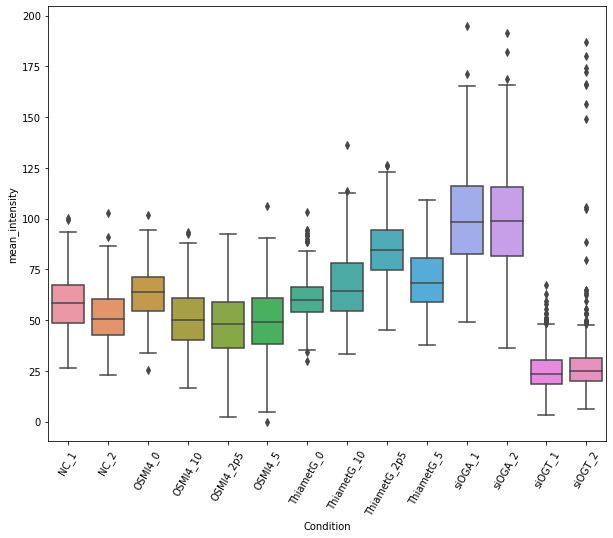

In [34]:
fig = plt.figure(figsize=(10,8))
g = sns.boxplot(x='Condition',y='mean_intensity',data=df_props_all)
g.set_xticklabels(g.get_xticklabels(),rotation=60);